In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.applications import VGG19

from sklearn.metrics import classification_report, confusion_matrix

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1-Business Understanding

The problem of classifying yoga pose images requires the automatic categorization of images depicting people performing various yoga poses. It falls under the domain of machine learning, specifically image recognition. To effectively perform the classification task, the model must be capable of analyzing the images and assigning them to their respective pose categories, such as mountain pose, head down pose, or warrior pose. One approach to accomplishing this is by utilizing image recognition algorithms like convolutional neural networks (CNNs).

# 2-Data Understanding

To get a general overview we look on the data structure of the train and test folder. In both folders there are folder with the same names. These subfolderes, labeled with the name of the underlying category, contains the images. The categories are:

downdog

goddess

plank

tree

warrior2

# 3-Loading and Preparing the Data

In [2]:
# Set the base path to the dataset directory in Kaggle
BASE_PATH = '/kaggle/input/yoga-poses-dataset/DATASET/'

In [3]:
# Loading Data
import os
import pandas as pd

filenames,labels = [],[]

for dirname in os.listdir(f'{BASE_PATH}TRAIN'):
    for file in os.listdir(f'{BASE_PATH}TRAIN/{dirname}'):
        filenames.append(file)
        labels.append(dirname)

df_train = pd.DataFrame(data={
    'filename': filenames,
    'labels': labels
})

### Visualize Data: Displaying 3 images from each label

In [59]:
def dataset_distribution(dataset_directory, title):
    nbr_imgs_per_class = []
    for directory in os.listdir(dataset_directory):
        nbr_imgs_per_class.append(len(os.listdir(os.path.join(dataset_directory, directory))))
    dataset_distribution = [nbr/sum(nbr_imgs_per_class)*100 for nbr in nbr_imgs_per_class]
    fix, ax = plt .subplots(figsize=(16, 8))
    plt.title(title)
    ax.pie(dataset_distribution, labels=["downdog", "goddess", "plank", "tree", "warrior2"], autopct='%1.1f%%', shadow=True, explode = (0.05, 0.05, 0.05, 0.05, 0.05))

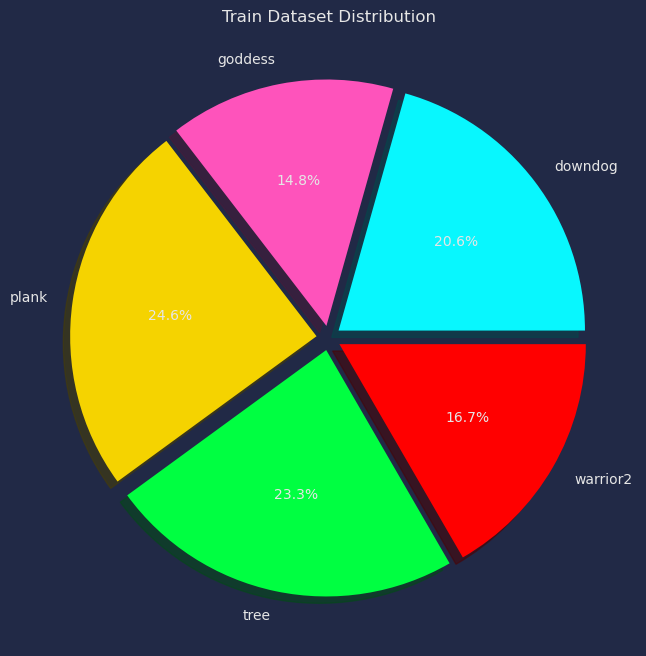

In [60]:
dataset_distribution("/kaggle/input/yoga-poses-dataset/DATASET/TRAIN", 'Train Dataset Distribution')

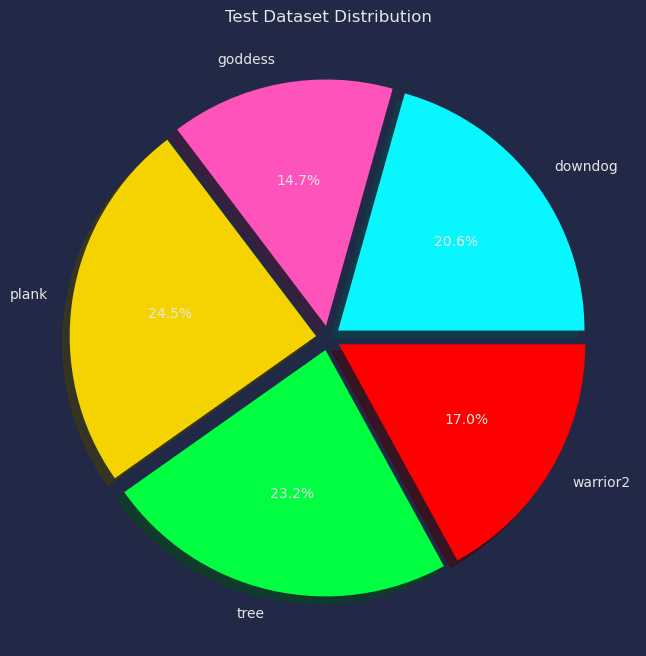

In [61]:
dataset_distribution("/kaggle/input/yoga-poses-dataset/DATASET/TEST", 'Test Dataset Distribution')

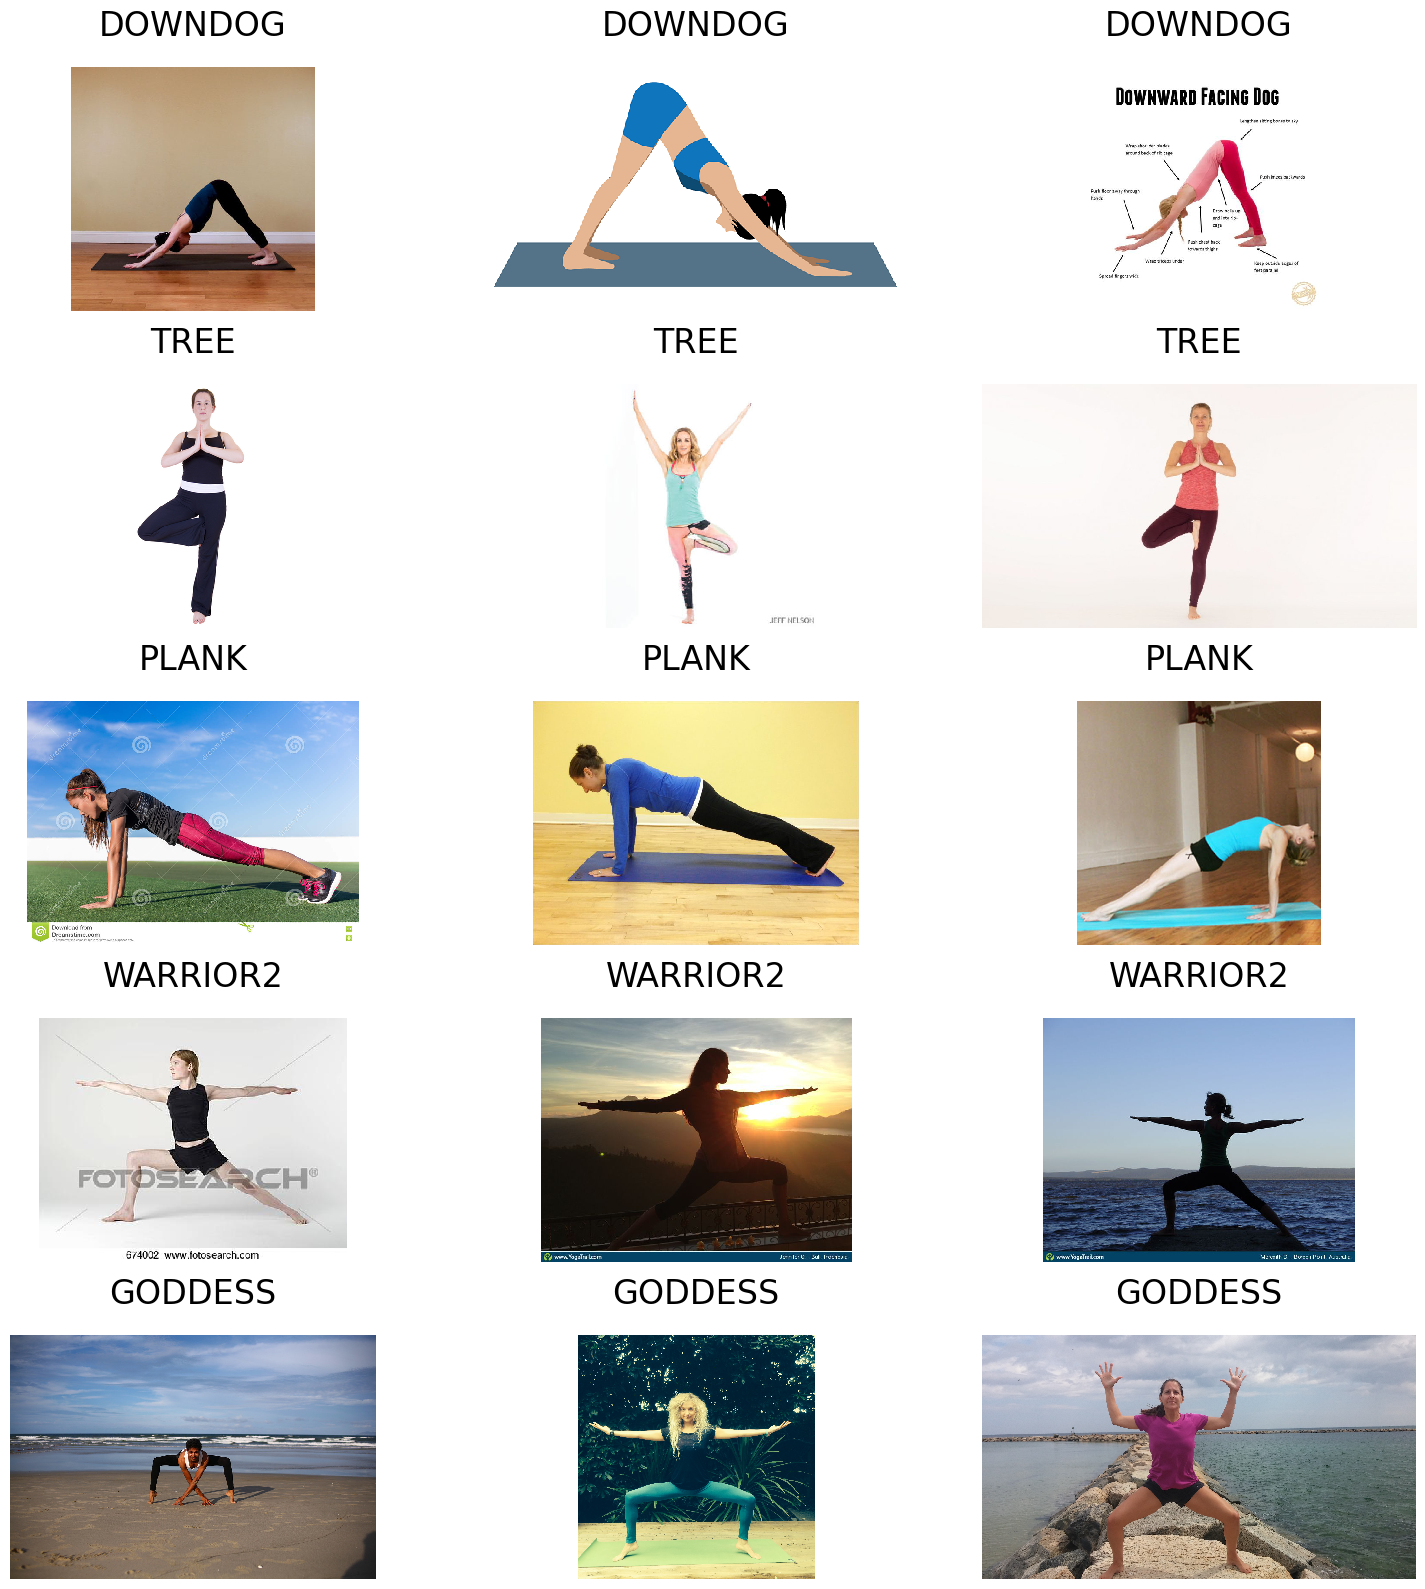

In [5]:
rows = 5
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
for i, row in enumerate(list(df_train.labels.unique())):
    for j, filename in enumerate(df_train[df_train.labels == row]['filename'].tolist()[:cols]):
        img = load_img(os.path.join(BASE_PATH,'TRAIN',row, filename))
        axs[i,j].matshow(img)
        axs[i,j].axis('off')
        axs[i,j].set_title(row.upper(), fontsize=24)
fig.tight_layout()


## Histogram Equalization




Histogram Equalization is used for improving the contrast of any image, that is- to make the dark portion darker and the bright portion brighter. For a grey-scale image, each pixel is represented by the intensity value (brightness); that is why we can feed the pixel values directly to the HE function. However, that is not how it works for an RGB-formatted color image. Each channel of the R, G, and B represents the intensity of the related color, not the intensity/brightness of the image as a whole. And so, running HE on these color channels is NOT the proper way. We should first separate the brightness of the image from the color and then run HE on the brightness. Now, there are already standardized colorspaces that encode brightness and color separately, like- YCbCr, HSV, etc.; so, we can use them here for separating and then re-merging the brightness

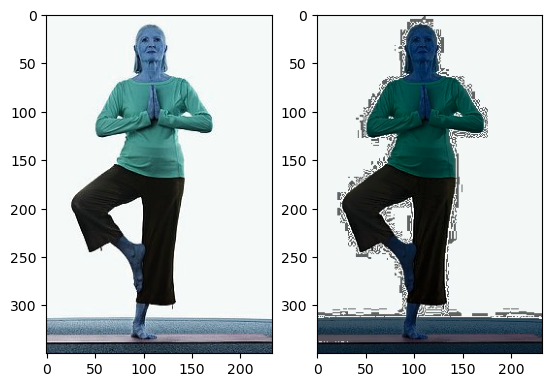

In [6]:

image = cv2.imread(BASE_PATH+'TRAIN/'+'tree/'+os.listdir(BASE_PATH+'TRAIN/'+'tree/')[4])

# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
 # equalize the histogram of the Y channel
ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

plt.subplot(121),plt.imshow(image)

plt.subplot(122),plt.imshow(equalized_img)
plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

Now the input image’s contrast has improved significantly but at the expense of also boosting the contrast of the noise in the input image. We can solve this problem by using adaptive histogram equalization

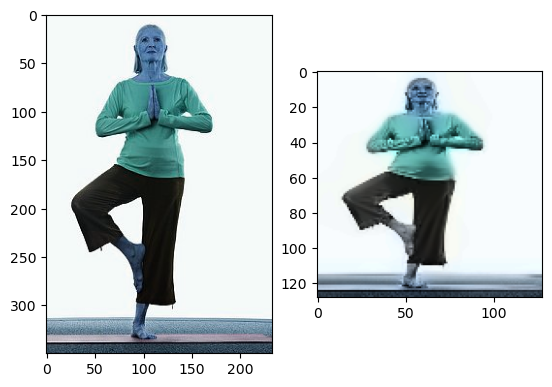

In [7]:
image = cv2.imread(BASE_PATH+'TRAIN/'+'tree/'+os.listdir(BASE_PATH+'TRAIN/'+'tree/')[4])
# dsize
dsize = (128,128)
resized_image = cv2.resize(image,dsize)
# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
# create a CLAHE object 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Now apply on the YCrCb image 
ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

# Denoise is done to remove unwanted noise to better perform
equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)

plt.subplot(121),plt.imshow(image)
plt.subplot(122),plt.imshow(equalized_denoised_image)
plt.show()

In [8]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize)
            # convert from BGR color-space to YCrCb
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label


In [9]:
train_path = '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'
test_path = '/kaggle/input/yoga-poses-dataset/DATASET/TEST'

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


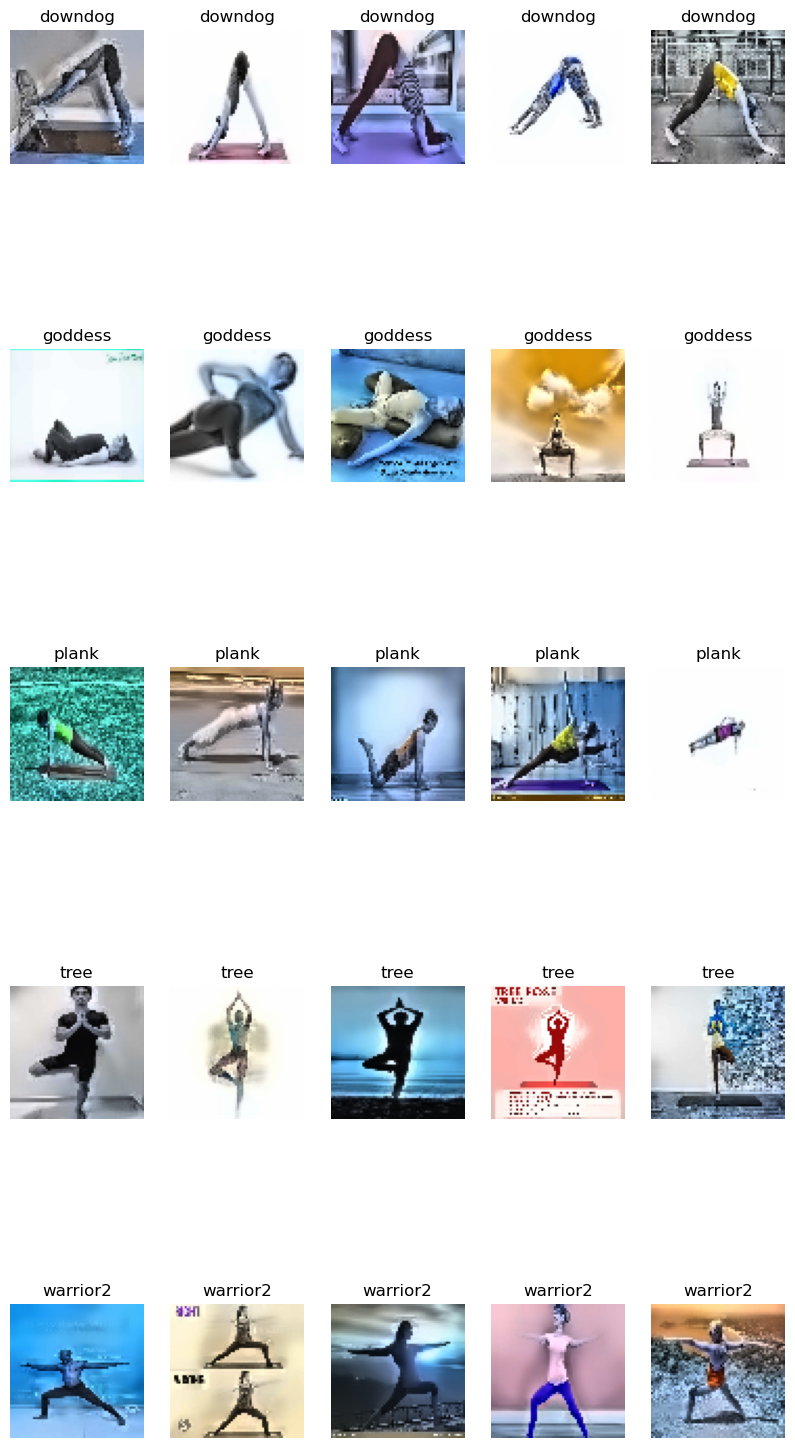

In [10]:
import matplotlib.pyplot as plt

# Load preprocessed images and their labels
images_data, images_label = preprocess_images(train_path)

# Define a dictionary to map class names to integers for plotting
class_dict = {class_name: i for i, class_name in enumerate(np.unique(images_label))}

# Plot a sample of images for each class
fig, axes = plt.subplots(len(class_dict), 5, figsize=(10,20))
for i, class_name in enumerate(class_dict):
    class_idx = np.where(images_label == class_name)[0]
    np.random.shuffle(class_idx)
    for j in range(5):
        img_idx = class_idx[j]
        axes[i][j].imshow(images_data[img_idx])
        axes[i][j].set_title(class_name)
        axes[i][j].axis('off')
plt.show()

This is a Python function that pre-processes images in a given directory. It takes one argument, dataset_path, which is the path to the directory containing the images. The function returns two numpy arrays: images_data and images_label.

The images_data array contains the pre-processed images, which have been resized, color equalized, denoised, and scaled to have values between 0 and 1. The images_label array contains the corresponding labels for each image.



In [11]:
train_images_data, train_images_label = preprocess_images(train_path)

Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


In [12]:
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [13]:
from sklearn import preprocessing
class_names = os.listdir(train_path)
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

Overall, this function is useful for converting categorical labels into numerical labels that can be used for various machine learning tasks such as classification or regression.

## CNN Model Development

In [14]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
model = tf.keras.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')
        
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        1

This is a code snippet for defining a Convolutional Neural Network (CNN) using the Keras API in TensorFlow. The model is built using a sequential architecture, which means that each layer is added sequentially to the model.

The first layer in the model is a Conv2D layer with 16 filters, a kernel size of (3,3), and the ReLU activation function. This layer expects an input shape of (64,64,3), which means that it can process images of size 64x64 with 3 color channels (RGB).

The second layer is a MaxPooling2D layer with a pool size of (2,2), which reduces the spatial dimensions of the output from the previous layer by a factor of 2.

The third layer is another Conv2D layer with 32 filters, a kernel size of (3,3), and the ReLU activation function.

The fourth layer is a BatchNormalization layer, which normalizes the activations of the previous layer across the batch dimension.

The fifth layer is a Dropout layer, which randomly drops out 25% of the activations of the previous layer during training, in order to reduce overfitting.

The sixth and seventh layers are similar to the third and fourth layers, but with 64 filters instead of 32.

The eighth layer is a Flatten layer, which flattens the output from the previous layer into a 1D tensor.

The ninth layer is a Dense layer with 512 units and the ReLU activation function.

The tenth layer is another BatchNormalization layer.

The eleventh layer is another Dropout layer, this time dropping out 50% of the activations.

The final layer is a Dense layer with a number of units equal to the number of classes in the classification problem, and the softmax activation function, which outputs a probability distribution over the classes.

The model.summary() function is used to print a summary of the model architecture, including the input/output shapes of each layer and the number of trainable parameters.

In [15]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 18.3 MB/s eta 0:00:0000:01


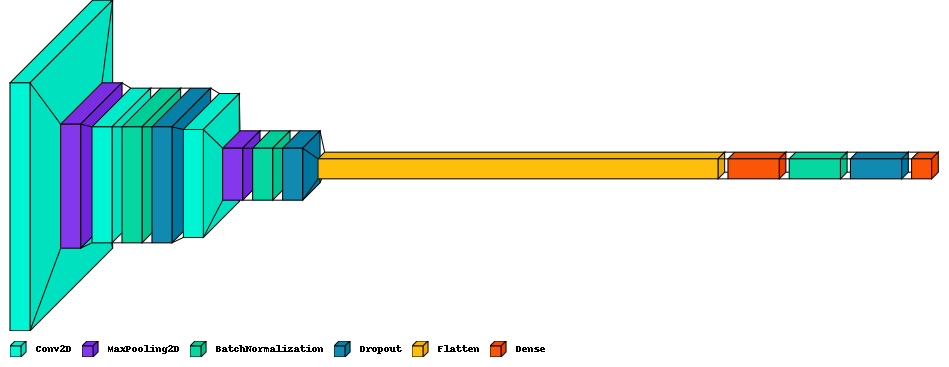

In [16]:
import visualkeras
from matplotlib import font_manager

from tensorflow.keras import layers
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib import font_manager
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
#color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True,color_map=color_map)

#  Training

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

epochs = 20
learning_rate = 0.001

opt = Adam(learning_rate=learning_rate)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate * 0.5**(epoch//10))
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### k-fold cross validation

In [23]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

In [24]:
model_path = '/kaggle/working/best_model.h5'

# Define a TensorBoard callback that will log metrics and activations during training
tensorboard_cb = TensorBoard(log_dir='weighs/logs', histogram_freq=1, write_graph=True, write_images=True)

In [25]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]),callbacks=[checkpoint, tensorboard_cb])
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 1.9617 - accuracy: 0.4201
Epoch 1: val_accuracy improved from -inf to 0.16129, saving model to best_model.h5
54/54 [==============================] - 13s 191ms/step - loss: 1.9617 - accuracy: 0.4201 - val_loss: 1.9630 - val_accuracy: 0.1613
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.6609
Epoch 2: val_accuracy improved from 0.16129 to 0.25346, saving model to best_model.h5
54/54 [==============================] - 10s 177ms/step - loss: 1.0662 - accuracy: 0.6609 - val_loss: 1.9192 - val_accuracy: 0.2535
Epoch 3/20
54/54 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.7442
Epoch 3: val_accuracy did not improve from 0.25346
54/54 [==============================] - 9s 174ms/step - loss: 0.7979 - accuracy: 0.7442 - val_loss: 2.1173 - val_accuracy: 0.1613
Epoch 

In [26]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 96.38141179084778 (+- 0.0725685771973864)
> Mean_Validation_Accuracy: 86.46842485666275 (+- 0.21975364756023774)


The mean training accuracy of 96.41% indicates that, on average, the model correctly predicted the training data labels for 96.43% of the samples in the dataset. This indicates that the model has learned the patterns in the training data well.

The mean validation accuracy of 87.45% indicates that the model performs well on the validation data as well, but not quite as well as it does on the training data.*** This suggests that the model may be overfitting to the training data to some extent, which is why the accuracy drops when tested on the validation set.***

The standard deviations of 0.07 and 0.189 for the training and validation accuracies respectively indicate how much the accuracies vary across different training runs. A low standard deviation suggests that the model's performance is consistent across different training runs, while a high standard deviation suggests that the model's performance can be highly variable.

In [27]:
# Load the best model weights
model.load_weights(model_path)

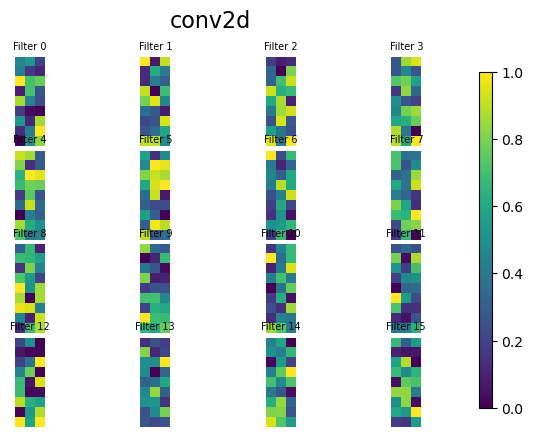

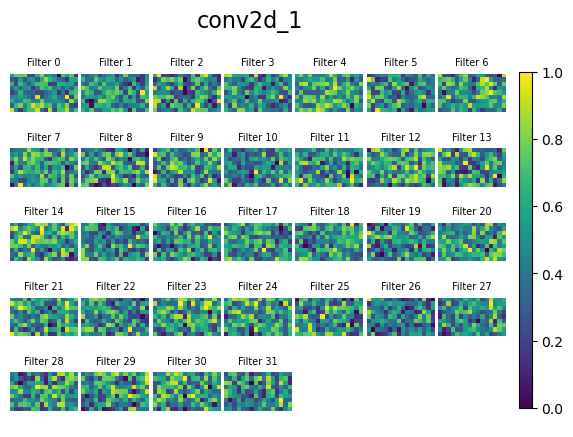

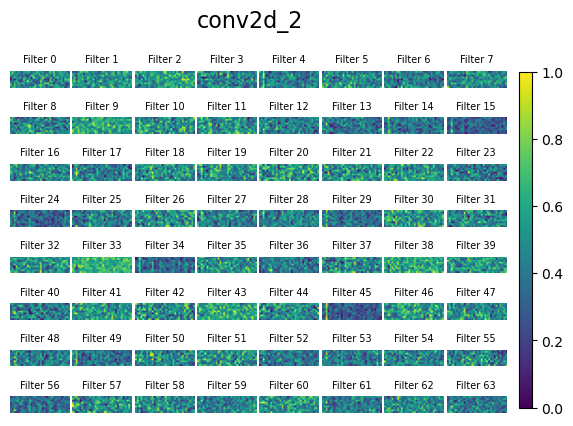

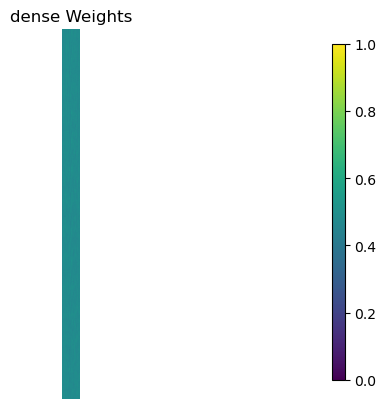

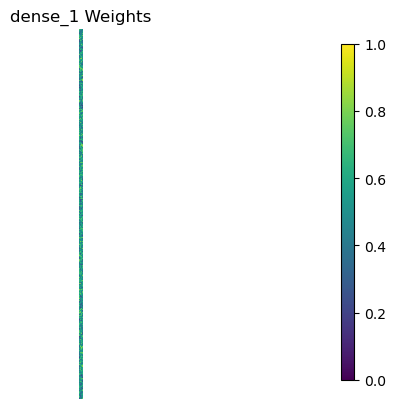

In [28]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model

# Get layer names of the model
layer_names = [layer.name for layer in model.layers]

# Loop over each layer of the model
for layer_name in layer_names:
    # Get the layer object
    layer = model.get_layer(layer_name)
    # Get the weights of the layer
    weights = layer.get_weights()
    # Check if weights are present
    if weights:
        # Unpack weights and biases if there are two arrays returned
        if len(weights) == 2:
            weights, biases = weights
        else:
            weights = weights[0]
            biases = None
        # Check if weights have 4 dimensions
        if weights.ndim == 4:
            # Get number of filters, rows and columns
            n_filters = weights.shape[3]
            rows = int(np.sqrt(n_filters))
            cols = int(np.ceil(n_filters / rows))
            # Create a figure and axes for the subplots
            fig, axs = plt.subplots(rows, cols)
            # Set the title of the figure
            fig.suptitle(layer_name, fontsize=16)
            # Loop over each filter of the layer
            for i in range(n_filters):
                row = i // cols
                col = i % cols
                # Extract the weights of the filter
                w = weights[:, :, :, i]
                # Normalize the weights between 0 and 1
                w_norm = (w - w.min()) / (w.max() - w.min())
                # Reshape the weights for display
                w_norm = np.reshape(w_norm, (w_norm.shape[0] * w_norm.shape[1], w_norm.shape[2]))
                # Display the filter weights in a subplot
                im = axs[row, col].imshow(w_norm)
                axs[row, col].axis('off')
                axs[row, col].set_title(f'Filter {i}', fontsize=7)
            # Add empty subplots to maintain layout for incomplete rows
            for i in range(n_filters, rows*cols):
                row = i // cols
                col = i % cols
                axs[row, col].axis('off')
            # Add colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            # Adjust spacing between subplots
            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            # Display the figure
            plt.show()
        # Check if weights have 2 dimensions
        elif weights.ndim == 2:
            # Create a figure and axes for the subplot
            fig, ax = plt.subplots(1, 1)
            # Normalize the weights between 0 and 1
            w_norm = (weights - weights.min()) / (weights.max() - weights.min())
            # Display the weights in a subplot
            im = ax.imshow(w_norm)
            ax.axis('off')
            ax.set_title(f'{layer_name} Weights', fontsize=12)
            # Add colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            # Display the figure
            plt.show()


## Evaluation

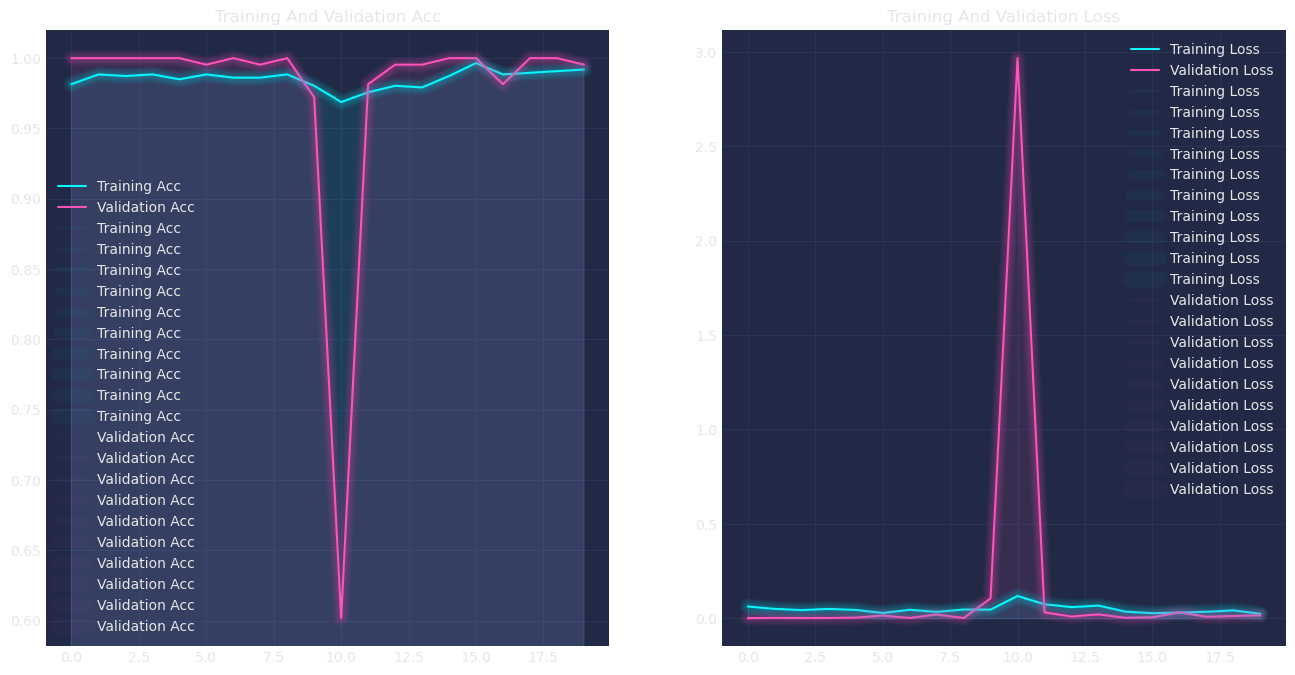

In [31]:
!pip install mplcyberpunk
import pathlib, os, random, mplcyberpunk


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.style.use('cyberpunk')
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
mplcyberpunk.add_glow_effects()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
mplcyberpunk.add_glow_effects()
plt.legend()

plt.show()

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 [==============================] - 1s 36ms/step
Test Data accuracy:  80.2127659574468

Confusion Matrix : 
[[83  3  8  0  3]
 [ 2 53  6  6 13]
 [ 4  0 99  1 11]
 [ 3  2  3 58  3]
 [ 2 19  3  1 84]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.88      0.86      0.87        97
        tree       0.69      0.66      0.68        80
       plank       0.83      0.86      0.85       115
    warrior2       0.88      0.84      0.86        69
     goddess       0.74      0.77      0.75       109

    accuracy                           0.80       470
   macro avg       0.80      0.80      0.80       470
weighted avg       0.80      0.80      0.80       470



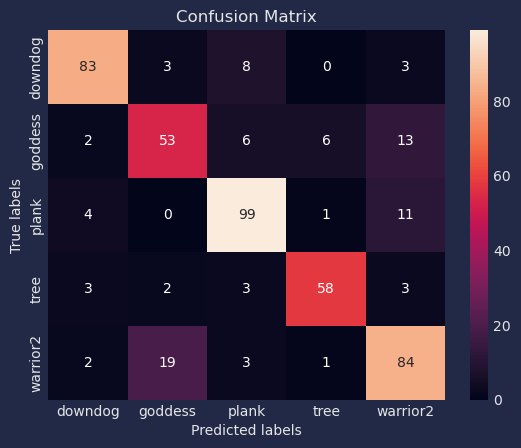

In [33]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);

### Data Augmentation

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=400

### Horizontal Flip

In [36]:
train_path = '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'
test_path = '/kaggle/input/yoga-poses-dataset/DATASET/TEST'

In [37]:
def plotimages(imagesls):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for image,ax in zip(imagesls, axes):
        ax.imshow(image)
        ax.axis('off')

Found 1081 images belonging to 5 classes.


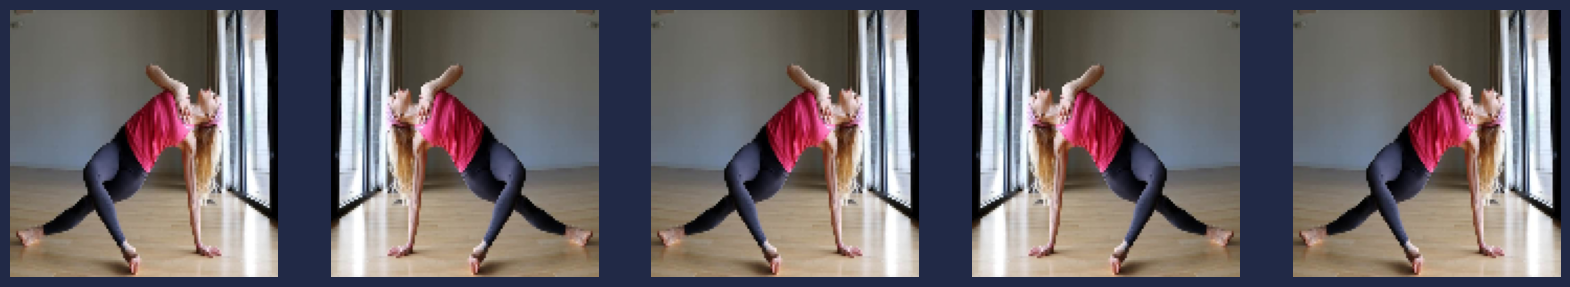

In [39]:
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=train_path,
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

Rotation

Found 1081 images belonging to 5 classes.


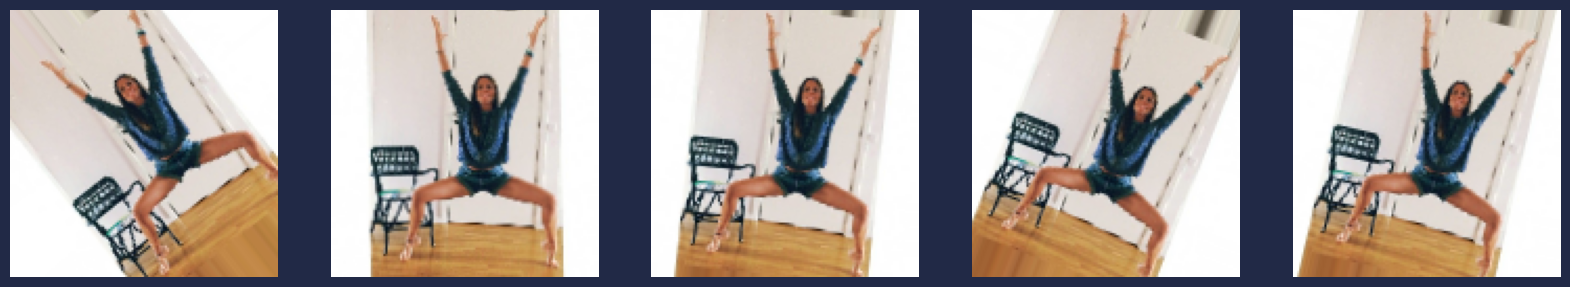

In [40]:
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory=train_path,
                                                       shuffle=True,
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

Zoom Augmentation

Found 1081 images belonging to 5 classes.


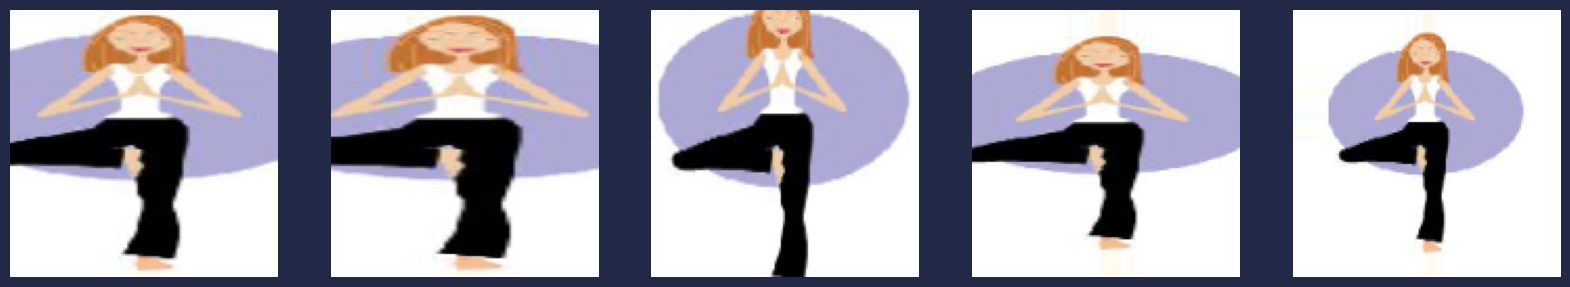

In [41]:
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=train_path,
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

### Pull Together

In [42]:
train_datagen = ImageDataGenerator(width_shift_range= 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split = 0.2)

train_generator =  train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 16,
                                                    subset = 'training')
validation_generator  = test_datagen.flow_from_directory(directory = test_path,
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  subset = 'validation')

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


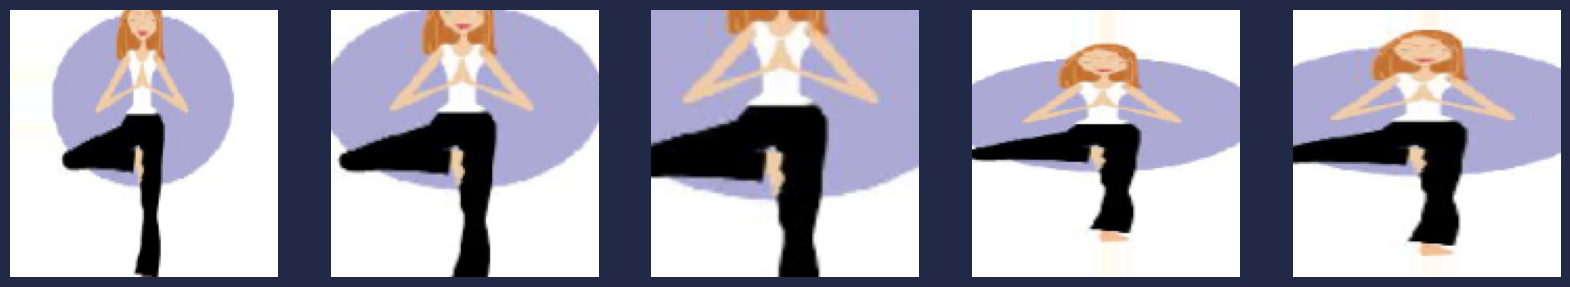

In [43]:
plotimages([train_data_gen[0][0][0] for i in range(5)])

In [44]:
dataAugmentaion = ImageDataGenerator(rotation_range = 10, zoom_range = 0.30, 
                                        fill_mode = "nearest", shear_range = 0.30)

### Retrain 

In [45]:
# from keras.callbacks import ModelCheckpoint, TensorBoard
# # Import the ModelCheckpoint and TensorBoard callbacks

# model_path2 = '/kaggle/working/best_model.h5'

# # Define the path to save the model weights

# checkpoint_cb = ModelCheckpoint(model_path2, monitor='val_accuracy', save_best_only=True, mode='max')
# # Define a ModelCheckpoint callback that will save the best weights based on validation accuracy

# tensorboard_cb = TensorBoard(log_dir='weighs2/logs', histogram_freq=1, write_graph=True, write_images=True)
# # Define a TensorBoard callback that will log metrics and activations during training

In [47]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit_generator(dataAugmentaion.flow(train_images_data[train], train_images_label[train], batch_size=16),
                                  epochs=epochs,
                                  validation_data=(train_images_data[valid], train_images_label[valid]),callbacks=[checkpoint, tensorboard_cb])
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.5556
Epoch 1: val_accuracy did not improve from 1.00000
54/54 [==============================] - 11s 174ms/step - loss: 1.6381 - accuracy: 0.5556 - val_loss: 1.8114 - val_accuracy: 0.6820
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.6481
Epoch 2: val_accuracy did not improve from 1.00000
54/54 [==============================] - 9s 172ms/step - loss: 1.1672 - accuracy: 0.6481 - val_loss: 4.3839 - val_accuracy: 0.4700
Epoch 3/20
54/54 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.6597
Epoch 3: val_accuracy did not improve from 1.00000
54/54 [==============================] - 9s 173ms/step - loss: 0.9734 - accuracy: 0.6597 - val_loss: 1.0270 - val_accuracy: 0.7558
Epoch 4/20
54/54 [==============================] - ETA: 0s - loss: 0.8470

In [48]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 89.27390277385712 (+- 0.0671714302037872)
> Mean_Validation_Accuracy: 90.34562194347382 (+- 0.1310924762633308)


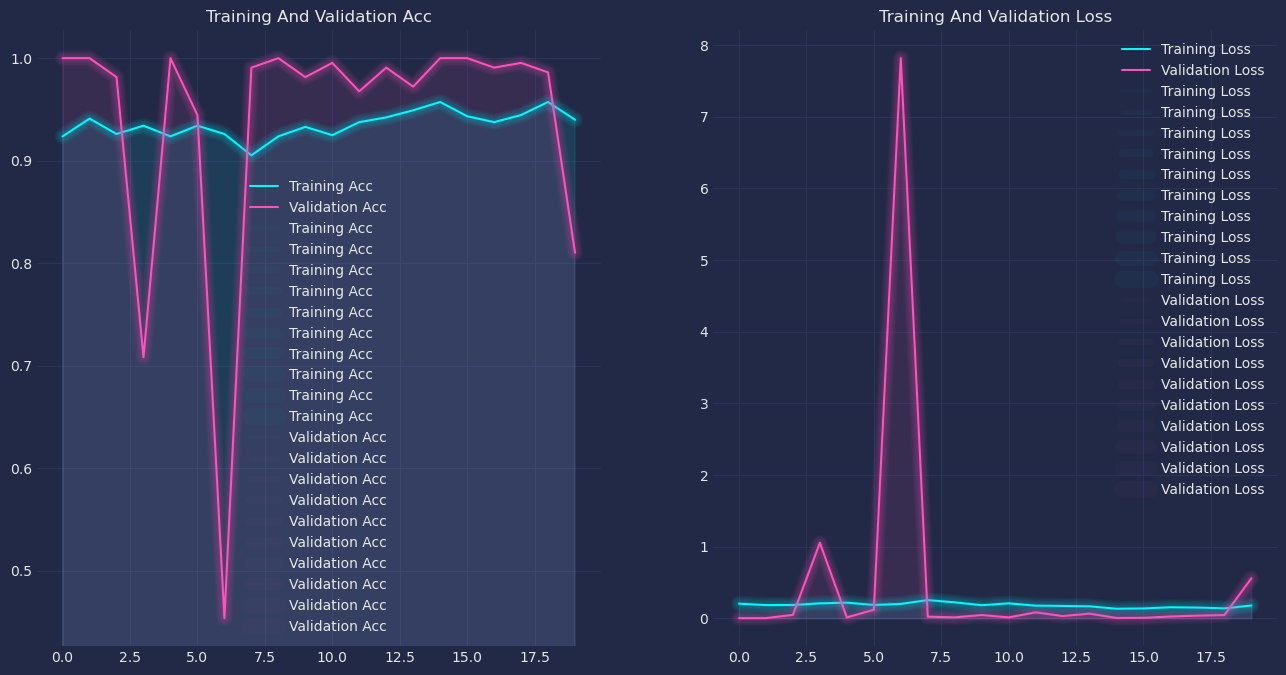

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.style.use('cyberpunk')
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
mplcyberpunk.add_glow_effects()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
mplcyberpunk.add_glow_effects()
plt.legend()

plt.show()

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 [==============================] - 1s 34ms/step
Test Data accuracy:  75.74468085106383

Confusion Matrix : 
[[ 82   1  12   0   2]
 [  0  37  11  14  18]
 [  1   1 106   1   6]
 [  0   2   6  54   7]
 [  0  11  18   3  77]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.99      0.85      0.91        97
        tree       0.71      0.46      0.56        80
       plank       0.69      0.92      0.79       115
    warrior2       0.75      0.78      0.77        69
     goddess       0.70      0.71      0.70       109

    accuracy                           0.76       470
   macro avg       0.77      0.74      0.75       470
weighted avg       0.77      0.76      0.75       470



## Trying Some hyperparameter Tuning

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
momentum = [0.3, 0.5, 0.7, 0.9]

In [ ]:
grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)

## Visualize weights

In [ ]:
# Load the best model weights
model.load_weights(model_path2)

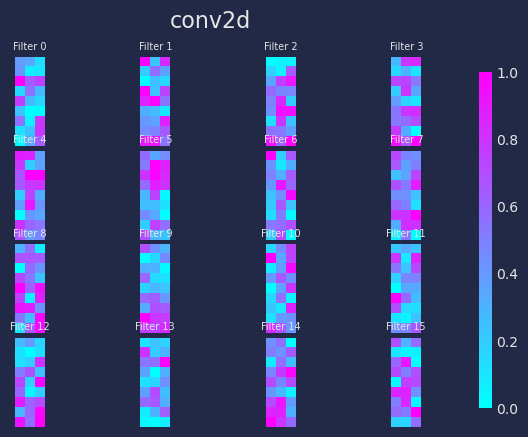

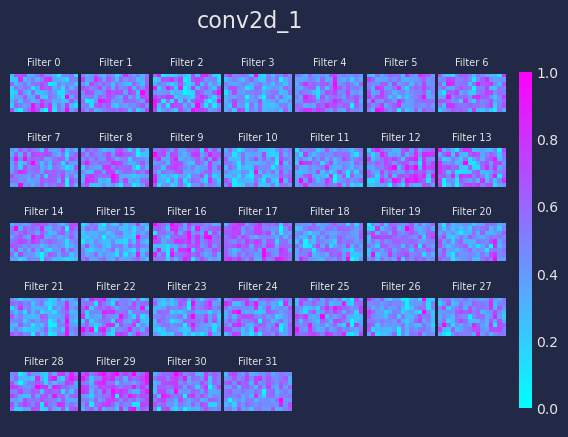

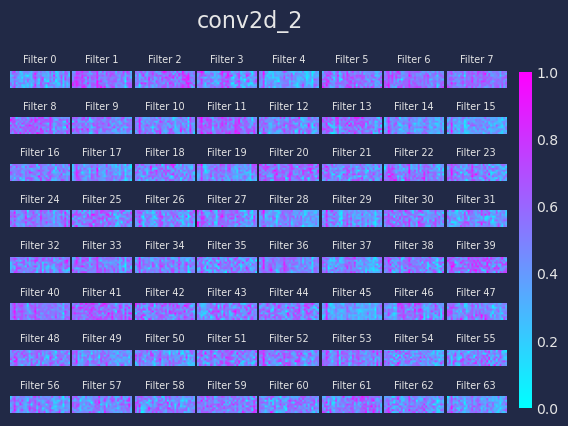

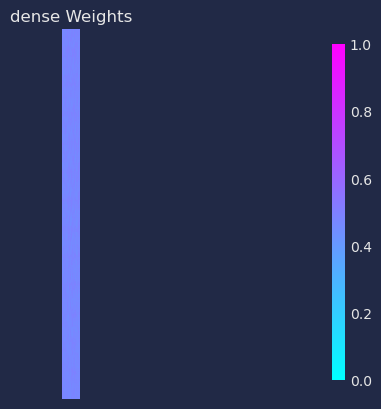

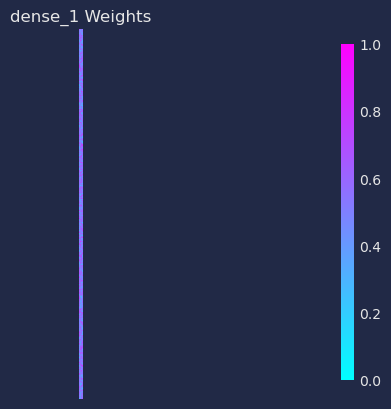

In [51]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model

# Get layer names of the model
layer_names = [layer.name for layer in model.layers]

# Loop over each layer of the model
for layer_name in layer_names:
    # Get the layer object
    layer = model.get_layer(layer_name)
    # Get the weights of the layer
    weights = layer.get_weights()
    # Check if weights are present
    if weights:
        # Unpack weights and biases if there are two arrays returned
        if len(weights) == 2:
            weights, biases = weights
        else:
            weights = weights[0]
            biases = None
        # Check if weights have 4 dimensions
        if weights.ndim == 4:
            # Get number of filters, rows and columns
            n_filters = weights.shape[3]
            rows = int(np.sqrt(n_filters))
            cols = int(np.ceil(n_filters / rows))
            # Create a figure and axes for the subplots
            fig, axs = plt.subplots(rows, cols)
            # Set the title of the figure
            fig.suptitle(layer_name, fontsize=16)
            # Loop over each filter of the layer
            for i in range(n_filters):
                row = i // cols
                col = i % cols
                # Extract the weights of the filter
                w = weights[:, :, :, i]
                # Normalize the weights between 0 and 1
                w_norm = (w - w.min()) / (w.max() - w.min())
                # Reshape the weights for display
                w_norm = np.reshape(w_norm, (w_norm.shape[0] * w_norm.shape[1], w_norm.shape[2]))
                # Display the filter weights in a subplot
                im = axs[row, col].imshow(w_norm)
                axs[row, col].axis('off')
                axs[row, col].set_title(f'Filter {i}', fontsize=7)
            # Add empty subplots to maintain layout for incomplete rows
            for i in range(n_filters, rows*cols):
                row = i // cols
                col = i % cols
                axs[row, col].axis('off')
            # Add colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            # Adjust spacing between subplots
            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            # Display the figure
            plt.show()
        # Check if weights have 2 dimensions
        elif weights.ndim == 2:
            # Create a figure and axes for the subplot
            fig, ax = plt.subplots(1, 1)
            # Normalize the weights between 0 and 1
            w_norm = (weights - weights.min()) / (weights.max() - weights.min())
            # Display the weights in a subplot
            im = ax.imshow(w_norm)
            ax.axis('off')
            ax.set_title(f'{layer_name} Weights', fontsize=12)
            # Add colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            # Display the figure
            plt.show()

## Visualize Mode

The chart shows the actual image and parts of it highlighted in shades of red and blue colors. The shades of red color show parts that contributed positively and shades of blue color show parts that contributed negatively to the prediction of that category

In [52]:
!pip install shap

Partition explainer: 6it [00:11, 11.72s/it]               


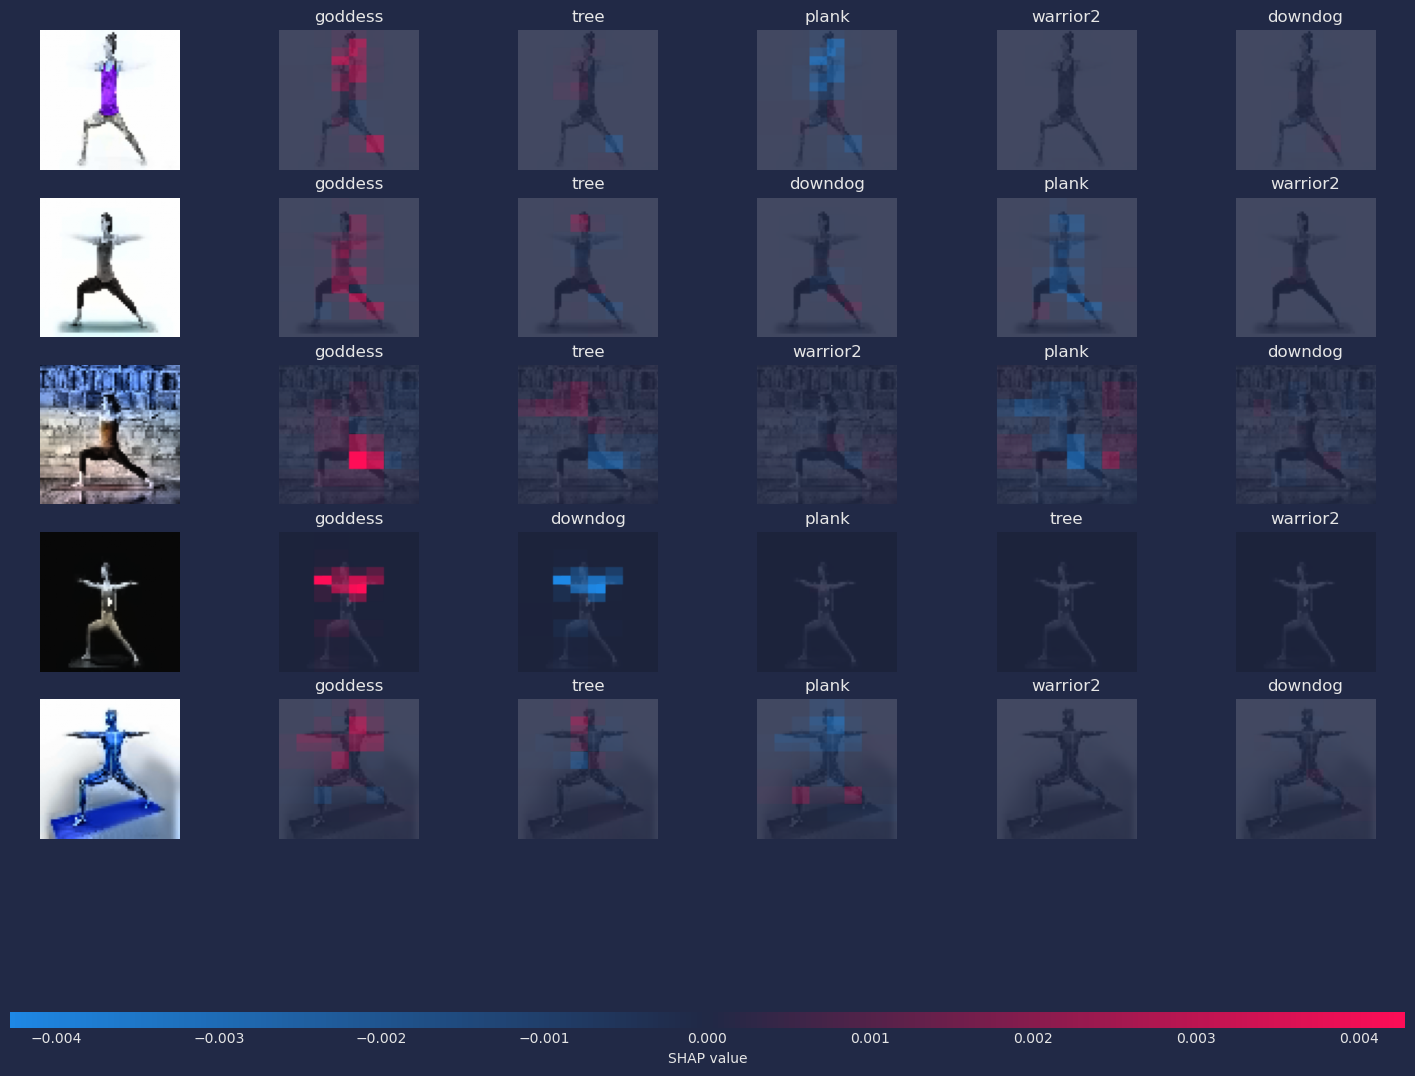

In [53]:
import shap
shap.initjs()
#Masker to mask parts of an image using blurring
masker = shap.maskers.Image("blur(64,64)", train_images_data[0].shape)
#Explainer() constructor by default creates an instance of Partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
#generate shap values for images using the explainer object
shap_values = explainer(test_images_data[361:366], outputs=shap.Explanation.argsort.flip[:5])
shap.image_plot(shap_values)
# SHAP values explain the contribution of each pixel or feature in the input image of the model's prediction
#it will allow us to visualize which parts or pixels that are most important to making prediction decisions 
#and generate insights into the function of the model 

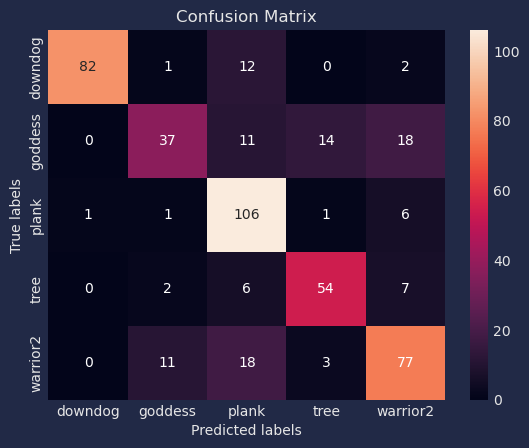

In [54]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);